<a href="https://colab.research.google.com/github/sampathmurala/AIMLOps/blob/main/M5_NB_MiniProject_3_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Sentiment Classification on Amazon Food Reviews

## Learning Objectives

At the end of the experiment, you will be able to :

* perform data preprocessing, EDA and feature extraction on the Amazon food review dataset
* load a pretraied BERT model from tensorflow hub
* finetune BERT model for sentiment classification

## Dataset description

The dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Data includes reviews from Oct 1999 - Oct 2012 period, with 568454 reviews, 256059 users, 74258 products, and 260 users with more than 50 reviews each.

The data is in CSV format with below features:

- ***Id:*** Row Id
- ***ProductId:*** Unique identifier for the product
- ***UserId:*** Unqiue identifier for the user
- ***ProfileName:*** Profile name of the user
- ***HelpfulnessNumerator:*** Number of users who found the review helpful
- ***HelpfulnessDenominator:*** Number of users who indicated whether they found the review helpful or not
- ***Score:*** Rating between 1 and 5
- ***Time:*** Timestamp for the review
- ***Summary:*** Brief summary of the review
- ***Text:*** Text of the review


##  Grading = 10 Points

## Information

Companies often receive thousands of reviews regarding their products which can be analysed to get incites on what customers think about their products.

Every positive review highlights the beneficial key features of the product, which can be replicated to other products making them more likable. On the other hand, every negative review highlights the weaknesses of the product, which can be treated as feedback to make improvements.

### Install dependencies

In [3]:
from IPython.display import clear_output

# Dependency of the preprocessing for BERT inputs
!pip -q install "tensorflow-text==2.13.*"
clear_output()
!pip -q install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.5 MB/s eta 0:00:00


### Import required packages

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import string

from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization     # to create AdamW optimizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model, Sequential

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/Reviews.csv
!ls | grep ".csv"

Reviews.csv


**Exercise 1: Read the Reviews.csv dataset**

**Hint:** pd.read_csv()

In [6]:
# Load the dataset
df = pd.read_csv('Reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Pre-processing and EDA

**Exercise 2: Perform below operations on the dataset [2 Marks]**

- Remove unnecessary columns - 'Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator'
- Check missing values
- Add a new `Sentiment` column using `Score` column ('positive' if score >=3)
- Remove duplicates from data considering `Sentiment` and `Text` columns
- Change `Time` in proper format


- **Remove unnecessary columns - 'Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator'**

In [8]:
df.drop(['Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductId    568454 non-null  object
 1   UserId       568454 non-null  object
 2   ProfileName  568438 non-null  object
 3   Score        568454 non-null  int64 
 4   Time         568454 non-null  int64 
 5   Summary      568427 non-null  object
 6   Text         568454 non-null  object
dtypes: int64(2), object(5)
memory usage: 30.4+ MB


- **Check missing values**

In [9]:
df.isnull().sum()

ProductId       0
UserId          0
ProfileName    16
Score           0
Time            0
Summary        27
Text            0
dtype: int64

In [10]:
# Drop missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductId    568411 non-null  object
 1   UserId       568411 non-null  object
 2   ProfileName  568411 non-null  object
 3   Score        568411 non-null  int64 
 4   Time         568411 non-null  int64 
 5   Summary      568411 non-null  object
 6   Text         568411 non-null  object
dtypes: int64(2), object(5)
memory usage: 34.7+ MB


- **Add a new `Sentiment` column using `Score` column**

Consider a review to be negative is the score is less than 3, else positive.

In [57]:
# Add 'Sentiment' column
df['Sentiment'] = df['Score'].apply(lambda h: 'Positive' if h >= 3 else 'Negative')

In [12]:
df.head(2)

,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative


- **Remove duplicates from data considering `Sentiment` and `Text` columns**

**Hint:** To check duplicate rows, refer [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html).

In [13]:
# Check duplicates
duplicates = df[df.duplicated(subset=['Sentiment', 'Text'], keep = False)]
duplicates.shape

(232866, 8)

In [14]:
# Remove duplicates
df = df.drop_duplicates(subset=['Sentiment', 'Text'])
df.shape

(393577, 8)

- **Change `Time` in proper format**

The Time is in unix time, change it in UTC.

Note: Unix time is a way of representing a timestamp by representing the time as the number of seconds since January 1st, 1970 at 00:00:00 UTC

In [16]:
# Convert Unix timestamp to UTC datetime
df['Time'] = df['Time'].apply(lambda ts: datetime.utcfromtimestamp(ts))
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393577 entries, 0 to 568453
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ProductId    393577 non-null  object        
 1   UserId       393577 non-null  object        
 2   ProfileName  393577 non-null  object        
 3   Score        393577 non-null  int64         
 4   Time         393577 non-null  datetime64[ns]
 5   Summary      393577 non-null  object        
 6   Text         393577 non-null  object        
 7   Sentiment    393577 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 27.0+ MB
None


,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Positive


**Exercise 3: Identify the `ProductId`s with highest number of positive and negative reviews. Use barplot. [0.5 Marks]**

In [17]:
review_counts = df.groupby(['ProductId', 'Sentiment']).size().unstack(fill_value=0)
review_counts['Total'] = review_counts['Positive'] + review_counts['Negative']

highest_positive = review_counts['Positive'].idxmax()
highest_negative = review_counts['Negative'].idxmax()
print(highest_positive, highest_negative)
review_counts

B007JFMH8M B000KV61FC


Sentiment,Negative,Positive,Total
ProductId,,,
0006641040,2,35,37
141278509X,0,1,1
2734888454,1,1,2
2841233731,0,1,1
7800648702,0,2,2
...,...,...,...
B009SF0TN6,0,1,1
B009SR4OQ2,0,1,1
B009UOFU20,1,0,1


In [25]:

# Group and format data
review_counts = df.groupby(['ProductId', 'Sentiment']).size().unstack(fill_value=0)
review_counts['Total'] = review_counts['Positive'] + review_counts['Negative']

# Identify ProductIds with the highest number of positive and negative reviews
highest_positive_product = review_counts['Positive'].idxmax()
highest_negative_product = review_counts['Negative'].idxmax()

print("Product with the highest number of positive reviews:", highest_positive_product)
print("Product with the highest number of negative reviews:", highest_negative_product)

# # Plot bar chart
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plotting bars for positive and negative reviews
# review_counts[['Positive', 'Negative']].plot(kind='bar', ax=ax, color=['green', 'red'])

# # Adding labels and title
# ax.set_title('Positive and Negative Reviews by ProductId')
# ax.set_xlabel('ProductId')
# ax.set_ylabel('Number of Reviews')

# plt.xticks(rotation=45)
# plt.legend(title='Sentiment')
# plt.tight_layout()

# plt.show()


Product with the highest number of positive reviews: B007JFMH8M
Product with the highest number of negative reviews: B000KV61FC


**Exercise 4: Identify the `UserId`s who has given highest number of positive and negative reviews. Use barplot. [0.5 Marks]**

In [26]:
user_review_counts = df.groupby(['UserId', 'Sentiment']).size().unstack(fill_value=0)
user_review_counts['Total'] = user_review_counts['Positive'] + user_review_counts['Negative']


# Identify UserIds with the highest number of positive and negative reviews
highest_positive_user = user_review_counts['Positive'].idxmax()
highest_negative_user = user_review_counts['Negative'].idxmax()

print("User with the highest number of positive reviews:", highest_positive_user)
print("User with the highest number of negative reviews:", highest_negative_user)

# # Plotting the bar plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plotting bars for positive and negative reviews
# review_counts.plot(kind='bar', ax=ax, color=['green', 'red'])

# # Adding labels and title
# ax.set_title('Positive and Negative Reviews by UserId')
# ax.set_xlabel('UserId')
# ax.set_ylabel('Number of Reviews')

# plt.xticks(rotation=45)
# plt.legend(title='Sentiment')
# plt.tight_layout()

# plt.show()


User with the highest number of positive reviews: AY12DBB0U420B
User with the highest number of negative reviews: AKZKG2Z7CNV27


**Exercise 5: Calculate and Visualize the year wise Positive Recommendation score. [1 Mark]**

- Extract `Year` from `Time` column

- Calculate $Positive\ Recommendation\ score_{year} = \frac{(positive\_review\_count\ -\ negative\_review\_count)}{(positive\_review\_count\ +\ negative\_review\_count)}$

In [27]:
# Extract Year
df['Year'] = df['Time'].dt.year

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393577 entries, 0 to 568453
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ProductId    393577 non-null  object        
 1   UserId       393577 non-null  object        
 2   ProfileName  393577 non-null  object        
 3   Score        393577 non-null  int64         
 4   Time         393577 non-null  datetime64[ns]
 5   Summary      393577 non-null  object        
 6   Text         393577 non-null  object        
 7   Sentiment    393577 non-null  object        
 8   Year         393577 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 30.0+ MB


In [36]:
# Calculate year wise Positive Recommendation score
year_review_counts = df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)
# year_review_counts['Total'] = year_review_counts['Positive'] + year_review_counts['Negative']
print("why (positive_review_count − negative_review_count)? is this formulae correct??")
# Calculate the Positive Recommendation score for each year
year_review_counts['Positive_Recommendation_Score'] = (year_review_counts['Positive']) / (year_review_counts['Positive'] + year_review_counts['Negative'])
year_review_counts

why (positive_review_count − negative_review_count)? is this formulae correct??


Sentiment,Negative,Positive,Positive_Recommendation_Score
Year,,,
1999,0,4,1.000000
2000,1,16,0.941176
2001,2,6,0.750000
2002,1,32,0.969697
2003,7,92,0.929293
2004,30,409,0.931663
2005,89,970,0.915958
2006,589,4133,0.875265
2007,1576,14175,0.899943


### Pre-process `Text` reviews

**Exercise 6: Create functions to perform below tasks: [1.5 Marks]**

- remove HTML, XML, etc. markup and metadata
- remove punctuations
- remove stopwords


- **Remove HTML, XML, etc.**


In [52]:
def remove_markup_metadata(text):
  """ Removes HTML, XML, and other markup and metadata from text. """
  soup = BeautifulSoup(text, "html.parser")
  return re.sub(r'<[^>]*>', '', soup.get_text())

- **Remove punctuations**

In [51]:
def remove_punctuation(text):
  """ Removes punctuation characters from text. """
  # Remove punctuation characters from the text
  return "".join([char for char in text if char not in string.punctuation])

- **Remove stopwords**

In [49]:
def remove_stopwords(text):
    """ Removes stopwords from text. """
    stopwords_list = set(stopwords.words('english'))

    # Convert text to lowercase and split into words and Remove stopwords from the list of words
    filtered_words = [word.lower() for word in word_tokenize(text) if word.lower() not in stopwords_list]
    # Join the filtered words back into a string
    return " ".join(filtered_words)

**Exercise 7: Convert `Sentiment` to numerical**

In [54]:
def convert_sentiment_to_numeric(sentiment):
    return 1 if sentiment == "Positive" else 0

In [58]:
df['Sentiment'] = df['Sentiment'].apply(convert_sentiment_to_numeric)
df.head()

,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Sentiment,Year
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,2011
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,2012
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1,2008
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,0,2011
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,1,2012


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393577 entries, 0 to 568453
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ProductId    393577 non-null  object        
 1   UserId       393577 non-null  object        
 2   ProfileName  393577 non-null  object        
 3   Score        393577 non-null  int64         
 4   Time         393577 non-null  datetime64[ns]
 5   Summary      393577 non-null  object        
 6   Text         393577 non-null  object        
 7   Sentiment    393577 non-null  int64         
 8   Year         393577 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 30.0+ MB


### Split data into train, validation, and test set

Use 20K samples for training, 20K for validation, and 20K for testing set.

Hint: To keep the class distribution same across sets, use `stratify` parameter while doing `train_test_split`.

In [92]:
X = df.drop(columns=['Sentiment']) #Features
y = df['Sentiment'] #Target

# Split data into train and test sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Split test set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Take 20K samples for each set
X_train = X_train[:20000]
y_train = y_train[:20000]
X_val = X_val[:20000]
y_val = y_val[:20000]
X_test = X_test[:20000]
y_test = y_test[:20000]

In [102]:
# Verify the shapes of the sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (20000, 8) (20000,)
Validation set shape: (20000, 8) (20000,)
Test set shape: (20000, 8) (20000,)


## Load model from TensorFlow Hub

In [62]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('Variable                     Name                             Handle')
print(f'tfhub_handle_encoder         BERT model selected            : {tfhub_handle_encoder}')
print(f'tfhub_handle_preprocess      Preprocess model auto-selected : {tfhub_handle_preprocess}')

Variable                     Name                             Handle
tfhub_handle_encoder         BERT model selected            : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
tfhub_handle_preprocess      Preprocess model auto-selected : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


**Exercise 8: Load the *preprocessing model* and selected *BERT model* from TF Hub into separate [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer)s to compose your fine-tuned model [0.5 Marks]**

In [112]:
# Load preprocessing model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [113]:
# Load BERT model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [116]:
text_test = X_train[['Text']].values[0]
text_preprocessed = bert_preprocess_model(text_test)

In [117]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1996 26389  1999  2023  5572  2024  6919  2135  3375  1011  5683]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [118]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-9.99916852e-01  1.46141043e-04 -9.99511898e-01  9.95877862e-01
 -9.99370039e-01  1.40760317e-01 -9.39494073e-01 -8.85863066e-01
  2.54907887e-02  1.09344475e-01 -6.97061598e-01 -1.28029302e-01]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.29207703 -0.9166205  -3.6241484  ... -0.6761053  -0.55349565
   0.84242785]
 [-1.2715061   0.3622078  -0.14141263 ... -1.9161654  -1.133212
   0.7805985 ]
 [-1.688505   -1.7885547  -0.15791543 ... -2.297629   -0.9448644
   0.96572465]
 ...
 [-0.7707387  -0.9722022   0.3365175  ... -2.3637838  -0.96695036
   1.6723107 ]
 [-1.0113021  -0.83148426 -0.28365    ... -1.5922061  -0.7870611
   1.5478648 ]
 [-0.36426088 -1.2165077  -0.41976064 ... -0.52071637 -0.9075167
   0.82107925]]


## Define your model

**Exercise 9: Create a fine-tuned model with the preprocessing model, the selected BERT model, Dense and Dropout layers [1 Mark]**

In [132]:
# Define a function to create custom classifier model using BERT
def build_classifier_model():
    # Define model inputs
    text_input = Input(shape=(), dtype=tf.string, name='text') # input layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') # text processing (text to numbers)

    encoder_inputs = preprocessing_layer(text_input) # one array to three array(mask, ids, sentence ids)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # define encoding layer
    encoder_outputs = encoder(encoder_inputs) # encoding

    net = encoder_outputs['pooled_output'] # input array for the classification model
    net = tf.keras.layers.Dropout(0.1)(net) # drouput layer
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net) # classification
    return tf.keras.Model(text_input, net)

In [133]:
# Custom classifier model
classifier_model = build_classifier_model()

In [134]:
bert_raw_result = classifier_model(tf.constant(X_train[['Text']].values[0]))
print(tf.sigmoid(bert_raw_result))       # apply sigmoid to keep the output within 0 to 1

tf.Tensor([[0.5165625]], shape=(1, 1), dtype=float32)


**Visualize model's structure**

In [136]:
classifier_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                            

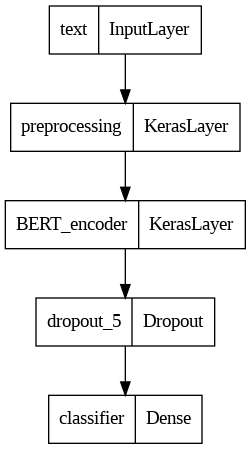

In [135]:
# Visualize model's structure
tf.keras.utils.plot_model(classifier_model)

## Model training

**Exercise 10: Define suitable loss function, metrics, and optimizer for model compilation [1 Mark]**

#### Loss function

In [149]:
# Define loss function and metric
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [150]:
optimizer=tf.keras.optimizers.Adam(1e-5)

In [151]:
# Hyperparameters ad Optimizer
epochs = 5

In [152]:
# Compile model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

**Exercise 11: Train and evaluate the model [1 Mark]**

In [153]:
# Train the model
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train['Text'],y= y_train,
                               validation_data=(X_val['Text'], y_val),
                               batch_size=32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/5
625/625 [==============================] - 535s 846ms/step - loss: 1.0520 - binary_accuracy: 0.6742 - val_loss: 0.4106 - val_binary_accuracy: 0.8554
Epoch 2/5
625/625 [==============================] - 516s 826ms/step - loss: 0.4142 - binary_accuracy: 0.8511 - val_loss: 0.3875 - val_binary_accuracy: 0.8554
Epoch 3/5
625/625 [==============================] - 468s 748ms/step - loss: 0.3839 - binary_accuracy: 0.8509 - val_loss: 0.3407 - val_binary_accuracy: 0.8562
Epoch 4/5
625/625 [==============================] - 414s 662ms/step - loss: 0.3283 - binary_accuracy: 0.8561 - val_loss: 0.2982 - val_binary_accuracy: 0.8713
Epoch 5/5
625/625 [==============================] - 434s 695ms/step - loss: 0.2944 - binary_accuracy: 0.8697 - val_loss: 0.2837 - val_binary_accuracy: 0.8762


In [156]:
# Predection on test set
loss, accuracy = classifier_model.evaluate(X_test['Text'], y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

625/625 [==============================] - 90s 144ms/step - loss: 0.2809 - binary_accuracy: 0.8776
Loss: 0.28091609477996826
Accuracy: 0.8775500059127808


**Exercise 12: Plot the training and validation loss for comparison, as well as the training and validation accuracy [1 Mark]**

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


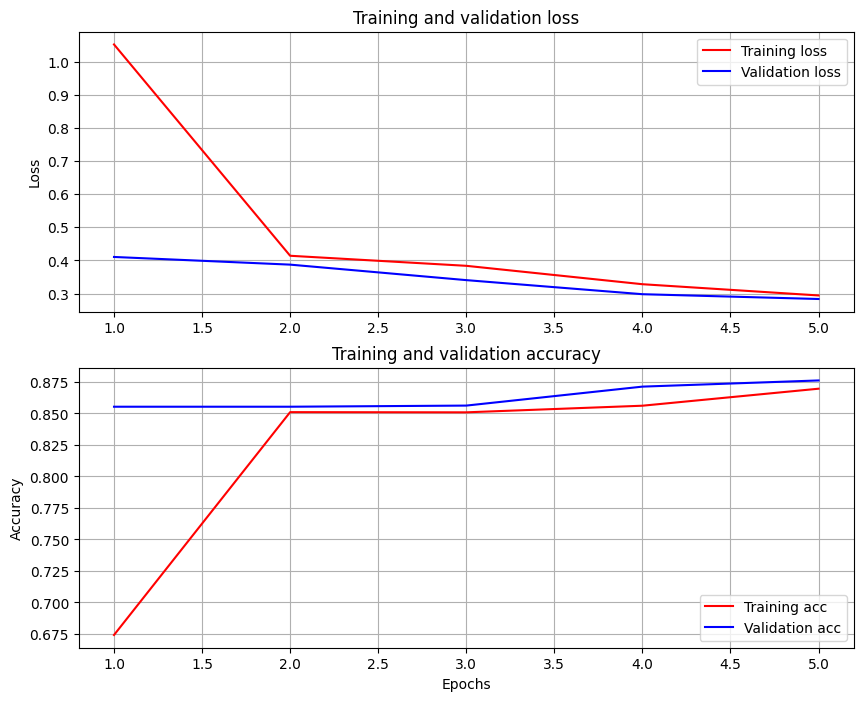

In [158]:
# Visualize loss and accuracy for training and validation sets
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Test Prediction

In [155]:
# Test your model on example sentences using both untuned and finetuned classifier model
examples = [
    "Fantastic product. Not exactly what I ordered, but five stars for Amazon.com fixing it",
    "Great taffy at a great price",
    "Best cereal ever made in history of time",
    'This is such an amazing product!',
    'Loved the taste and texture',
    'The product was great!',
    'The product was meh.',
    'The product was okish.',
    "Packet was torn, didn't like it",
    'The product was terrible...',
    "Didn't get what was pictured",
    "Not Helping Me on My Diet",
]

def print_my_examples(inputs, results):
    result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

# Prediction using the Untuned classifier model
untuned_classifier_model = build_classifier_model()
untuned_results = tf.sigmoid(untuned_classifier_model(tf.constant(examples)))

# Prediction using finetuned classifier model
reloaded_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the untuned model:')
print_my_examples(examples, untuned_results)

print('Results from the finetuned model:')
print_my_examples(examples, reloaded_results)

Results from the untuned model:
input: Fantastic product. Not exactly what I ordered, but five stars for Amazon.com fixing it : score: 0.274170
input: Great taffy at a great price   : score: 0.207320
input: Best cereal ever made in history of time : score: 0.314803
input: This is such an amazing product! : score: 0.262243
input: Loved the taste and texture    : score: 0.232701
input: The product was great!         : score: 0.275242
input: The product was meh.           : score: 0.255274
input: The product was okish.         : score: 0.274469
input: Packet was torn, didn't like it : score: 0.270231
input: The product was terrible...    : score: 0.171864
input: Didn't get what was pictured   : score: 0.352104
input: Not Helping Me on My Diet      : score: 0.251141

Results from the finetuned model:
input: Fantastic product. Not exactly what I ordered, but five stars for Amazon.com fixing it : score: 0.592391
input: Great taffy at a great price   : score: 0.983972
input: Best cereal ever 

## Save model

In [159]:
# Save model for later use
saved_model_path = 'amazon_food_review_bert'
classifier_model.save(saved_model_path, include_optimizer=False)